# Doohickey Gamma 0.7
---
[aicrumb](https://twitter.com/aicrumb)

In [1]:
#@title Install required libraries / Log in to the 🤗 hub
import os
from IPython.display import clear_output
import time
if not os.path.exists("installed.txt"):
    # red lines, it's fines, that's what i always say
    !pip install transformers lpips accelerate -q
    !pip install git+https://github.com/huggingface/diffusers
    !pip install git+https://github.com/openai/CLIP -q
    !pip install open_clip_torch omegaconf -q
    !pip install wget -q
    !sudo apt-get install git-lfs
    !cat "test" > installed.txt
    !mkdir /content/output
    print("Installed libraries")
    time.sleep(1) # just so that the user can see a glimpse of the print to know it went succesfuly
    clear_output(wait=False)
else:
    print("Libraries already installed.")

from huggingface_hub import notebook_login
notebook_login()

Libraries already installed.


In [2]:
#@title Import libraries / models
import torch
torch.manual_seed(0)
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler, DDIMScheduler, KarrasVeScheduler, PNDMScheduler, DDPMScheduler
from IPython.display import Image, display
from tqdm.auto import tqdm, trange
from torch import autocast
import PIL.Image as PImage
import PIL
import numpy as np
from torchvision import transforms
import torchvision.transforms.functional as f
import torch.nn.functional as F
import random
import requests
from io import BytesIO
from huggingface_hub import hf_hub_download
import diffusers

torch.backends.cudnn.benchmark = True

# Set device
torch_device = "cuda"
offload_device = "cpu"

model_name = "runwayml/stable-diffusion-v1-5" #@param {"type":"string"}

if ".ckpt" in model_name:
    !curl https://raw.githubusercontent.com/huggingface/diffusers/039958eae55ff0700cfb42a7e72739575ab341f1/scripts/convert_original_stable_diffusion_to_diffusers.py > convert.py
    !rm -r output-model
    repo_id = '/'.join(model_name.split("/")[:2])
    filename = '/'.join(model_name.split("/")[2:])
    print(repo_id, filename)
    compvis_path = hf_hub_download(repo_id=repo_id, filename=filename)

    !python convert.py --checkpoint_path "$compvis_path" --dump_path "output-model"
    model_name = "output-model"
    clear_output(wait=False)
    print("Model converted and saved at", model_name)


custom_vae = "" #@param {type:"string"}
if custom_vae!="":
    vae_model_name = "/".join(custom_vae.split("/")[:2])
    vae_subfolder = "/".join(custom_vae.split("/")[2:])
else:
    vae_model_name = model_name
    vae_subfolder = "vae"
vae = AutoencoderKL.from_pretrained(vae_model_name, subfolder=vae_subfolder, use_auth_token=True)

try:
    tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")
except:
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
    print("Could not load CLIP model from repo.")

unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", use_auth_token=True)

vae = vae.half().to(torch_device).eval()
text_encoder = text_encoder.half().to(torch_device).eval()
unet = unet.half().to(torch_device).eval()

In [3]:
import accelerate

offload_unet_to_disk = False #@param {type:"boolean"}
!rm -r text_encoder_offload
!rm -r vae_offload
!rm -r unet_offload

!mkdir text_encoder_offload
!mkdir vae_offload
!mkdir unet_offload
text_encoder.text_model.encoder = accelerate.big_modeling.disk_offload(text_encoder.text_model.encoder.cpu(), "text_encoder_offload", torch.device("cuda"),)
vae = accelerate.big_modeling.disk_offload(vae.cpu(), "vae_offload", torch.device("cuda"))

if offload_unet_to_disk:
    unet = accelerate.big_modeling.disk_offload(unet.cpu(), "unet_offload", torch.device("cuda"))

### Model Customizations

In [4]:
#@title load textual-inversion concepts from 🤗 hub

#@markdown `specific_concepts` can be a list of strings, containing the ids of your concepts (from sd-concepts-library or your own repos, example `["sd-concepts-library/my-first-inversion", "sd-concepts-library/my-second-inversion"]` etc.)

from huggingface_hub import HfApi
!pip install wget -q
import wget
import os
import requests
from huggingface_hub import hf_hub_download
api = HfApi()
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
        loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
        
        # separate token and the embeds
        trained_token = list(loaded_learned_embeds.keys())[0]
        embeds = loaded_learned_embeds[trained_token]

        # cast to dtype of text_encoder
        dtype = text_encoder.get_input_embeddings().weight.dtype
        embeds.to(dtype)

        # add the token in tokenizer
        token = token if token is not None else trained_token
        num_added_tokens = tokenizer.add_tokens(token)
        i = 1
        # while(num_added_tokens == 0):
        #     print(f"The tokenizer already contains the token {token}.")
        #     token = f"{token[:-1]}-{i}>"
        #     print(f"Attempting to add the token {token}.")
        #     num_added_tokens = tokenizer.add_tokens(token)
        #     i+=1
        
        # resize the token embeddings
        text_encoder.resize_token_embeddings(len(tokenizer))
        
        # get the id for the token and assign the embeds
        token_id = tokenizer.convert_tokens_to_ids(token)
        text_encoder.get_input_embeddings().weight.data[token_id] = embeds
        return token

specific_concepts = [] #@param

models = []
for model in specific_concepts:
    model_content = {}
    model_content["id"] = model
    embeds = (model, "learned_embeds.bin")
    embeds_file = hf_hub_download(embeds[0], embeds[1])
    
    token_identifier = (model, "token_identifier.txt")
    tokens_file = hf_hub_download(token_identifier[0], token_identifier[1])
    # print(f"added {token_name}")
    token_name = open(tokens_file, "r").read()
    print("adding", token_name)

    learned_token = load_learned_embed_in_clip(embeds_file, text_encoder, tokenizer, token_name)
    model_content["token"] = learned_token
    models.append(model_content)



In [5]:
#@title convert old embedding

#@markdown convert original textual-inversion embeds to huggingface-style ones <br> You can run this cell however many times is needed to input all of your inversions.

from IPython.display import FileLink
import torch

input_file = "" #@param {"type":"string"}
placeholder_token = "<my-style>" #@param {"type":"string"}

def convert_and_load(input_file, placeholder_token):
    x = torch.load(input_file, map_location=torch.device('cpu'))

    params_dict = {
        placeholder_token: torch.tensor(list(x['string_to_param'].items())[0][1])
    }
    torch.save(params_dict, "learned_embeds.bin")
    load_learned_embed_in_clip("learned_embeds.bin", text_encoder, tokenizer, placeholder_token)
    print("loaded", placeholder_token)

if input_file != "":
    convert_and_load(input_file, placeholder_token)

In [6]:
#@markdown load a few midjourney styles
import gdown
gdown.download_folder(url="https://drive.google.com/drive/u/9/folders/1whqzuBtiAIo9V12I20I1EVkfE9TLb1hS", quiet=True)

try:
    folder = "/content/midj textual inversion"
    files = [folder+"/"+i for i in os.listdir(folder) if ".pt" in i]
except: # WHY DOES IT SOMETIMES DO THIS AND SOMETIMES DO IT THE OTHER WAY????? IM SO ANGRY
    folder = "/content"
    files = [folder+"/"+i for i in os.listdir(folder) if ".pt" in i]
names = ["<"+i.split("/")[-1].split(".")[0]+">" for i in files]

for i,j in zip(files, names):
    convert_and_load(i,j)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


loaded <midj-strong>
loaded <midj-portrait>
loaded <midj-anthro>


In [7]:
#@title set up CLIP related functions
import open_clip as clip
from torch import nn
import torch.nn.functional as F
import io

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

def get_clip_model(name, pretrained="openai", cutn = 4):
    clip_model, _, preprocess = clip.create_model_and_transforms(clip_model_name, pretrained=clip_model_pretrained)
    clip_model = clip_model.eval().requires_grad_(False).to(torch_device)
    make_cutouts = MakeCutouts(clip_model.visual.image_size if type(clip_model.visual.image_size)!= tuple else clip_model.visual.image_size[0], cutn)
    return clip_model, make_cutouts

target = None
clip_model = None

def spherical_distance(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    l = (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2).mean()
    return l 

def clip_loss(x):
    global clip_model 
    global target
    global make_cutouts

    global unet 
    global vae

    if not offload_unet_to_disk: unet = unet.cpu()
    # vae = vae.cpu()

    cutouts = make_cutouts(x)
    clip_model = clip_model.half().cuda()
    encoding = clip_model.encode_image(cutouts.half().cuda())#.half()
    clip_model = clip_model.half().cpu()

    loss = spherical_distance(encoding, target)

    if not offload_unet_to_disk: unet = unet.cuda()
    # vae = vae.cuda()
    return loss.mean()

### Generate

Using seed: 51384
Creating CLIP Text Target..


  0%|          | 0/20 [00:00<?, ?it/s]

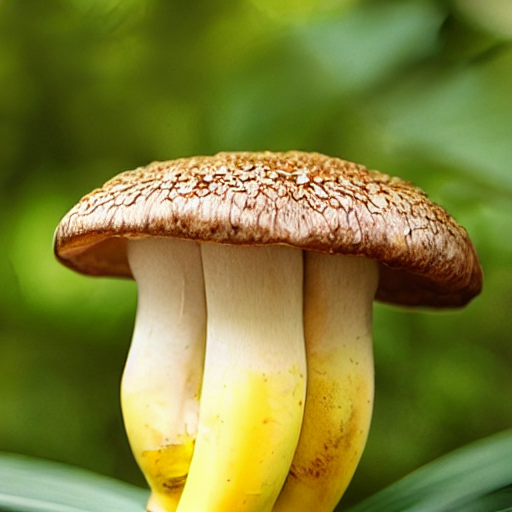

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
target = None
#@markdown Main Parameters
prompt = "a mushroom made of banana" #@param {type:"string"}
negative = "" #@param {type:"string"}
width_height = [512, 512] #@param
width, height = width_height
steps = 20 #@param

scheduler_type = "dpmsolver++" #@param ["dpmsolver++", "euler", "euler_a", "lms"]

if scheduler_type=="dpmsolver++":
    scheduler = diffusers.DPMSolverMultistepScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
        trained_betas=None,
        predict_epsilon=True,
        thresholding=False,
        algorithm_type="dpmsolver++",
        solver_type="midpoint",
        lower_order_final=True,
        solver_order=3
    )
else:
    default_config = {
        "beta_end": 0.012,
        "beta_schedule": "scaled_linear",
        "beta_start": 0.00085,
        "num_train_timesteps":1000
    }
    sch_map = {
        "euler": diffusers.EulerDiscreteScheduler,
        "euler_a": diffusers.EulerAncestralDiscreteScheduler,
        "ddim": diffusers.DDIMScheduler,
        # "ddpm": diffusers.DDPMScheduler,
        "lms": diffusers.LMSDiscreteScheduler
    }
    scheduler = sch_map[scheduler_type](**default_config)

scheduler.set_timesteps(steps)
scale = 0.1 #@param


batches = 16 #@param
attention_slice_size = "1" #@param [1, 2, 4, 8, "None"]
if attention_slice_size != "None":
    unet.set_attention_slice(int(attention_slice_size))

seed = -1 #@param
if seed == -1:
    seed = random.randint(1, 100_000)
    print("Using seed:", seed)
torch.manual_seed(seed)

experimental_cfg = True #@param {type:"boolean"}
#@markdown ---
#@markdown Classifier Guidance

clip_model_name = "ViT-B-16" #@param {type:"string"}
clip_model_pretrained = "openai" #@param {type:"string"}
cutn = 1 #@param

clip_text_prompt = "a mushroom made of hamburger" #@param {type:"string"}
clip_image_prompt = "" #@param {type:"string"}

def fetch(url_or_path):
    import io
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return PImage.open(fd).convert('RGB')
    return PImage.open(open(url_or_path, 'rb')).convert('RGB')

clip_scale = 0. #@param
clamp_max = 0.01 #@param
if clip_scale != 0:
    clip_model, make_cutouts = get_clip_model(clip_model_name, clip_model_pretrained, cutn)
    clip_model.cuda()

    input_tokens = clip.tokenize(clip_text_prompt).cuda()
    if len(clip_text_prompt) > 1:
        with torch.no_grad():
            print("Creating CLIP Text Target..")
            target = clip_model.encode_text(clip.tokenize(clip_text_prompt).to(torch_device))
            target = target.detach().requires_grad_(False)
            clip_model.transformer = None # we dont use it, delete to save vram
    if clip_image_prompt != "":
        with torch.no_grad():
            if target!=None:
                print("Creating CLIP Image Target.. (adding)")
                new_target = clip_model.encode_image(make_cutouts(f.to_tensor(fetch(clip_image_prompt)).unsqueeze(0).to(torch_device))).mean(0).unsqueeze(0)
                target = target * 0.5 + new_target
            else:
                print("Creating CLIP Image Target.. (new)")
                target = clip_model.encode_image(make_cutouts(f.to_tensor(fetch(clip_image_prompt)).unsqueeze(0).to(torch_device))).mean(0).unsqueeze(0)
    # else:
    #     raise Exception("You need to set a clip_text_prompt")
losses = [
    {
        "name": "clip_loss",
        "function": clip_loss,
        "scale": clip_scale
    }
]
guidance=False
for i in losses:
    if i['scale'] != 0:
        guidance = True

#@markdown ---
#@markdown Img2Img
input_strength = 0. #@param
strength = 1 - input_strength
input_url = "" #@param {type:"string"}

def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0
def latents_to_pil(latents):
    # grokking notebook
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents.half())['sample']
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [PImage.fromarray(image) for image in images]
    return pil_images
def generate(
    unet = unet,
    vae = vae,
    text_encoder = text_encoder,
    scheduler = scheduler,
    #######################
    prompt = prompt,
    negative = negative,
    width_height = width_height,
    width = width,
    height = height,
    steps = steps,
    scale = scale,
    experimental_guidance = experimental_cfg,
    ########################
    losses = losses,
    ######################
    strength = strength,
    input_url = input_url
):
    if input_url!="":
        with torch.no_grad():
            input_pil_image = fetch(input_url).resize(width_height)
            init_image = preprocess(input_pil_image)

            init_image = init_image.cuda().half()

            # vae.cuda()
            with torch.no_grad():
                init_latent_dist = vae.encode(init_image).latent_dist
            # vae.cpu()

            init_latents = init_latent_dist.sample()
            init_latents = 0.18215 * init_latents

            # get the original timestep using init_timestep
            offset = scheduler.config.get("steps_offset", 0)
            init_timestep = int(steps * strength) + offset
            init_timestep = min(init_timestep, steps)
            timesteps = scheduler.timesteps[-init_timestep]
            timesteps = torch.tensor([timesteps], device='cuda')

            # add noise to latents using the timesteps
            noise = torch.randn(init_latents.shape, device='cuda', dtype=torch.half)
            latents = scheduler.add_noise(init_latents, noise, timesteps)

        # I know this is messy and ugly but (at the time of writing) it's required
        del timesteps
        del init_latent_dist
        del init_image
        del noise

    with torch.no_grad():
        # text_encoder.cuda()
        tokens_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        tokens_negative = tokenizer(negative, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        prompt_embedding = text_encoder(tokens_prompt.input_ids.to(torch_device))[0]
        negative_embedding = text_encoder(tokens_negative.input_ids.to(torch_device))[0]
        # text_encoder.cpu()
    if input_url=="":
        latents = torch.randn(1, 4, height // 8, width // 8)
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma
    with torch.autocast("cuda"):
        if input_url!="":
            t_start = max(steps - init_timestep + offset, 0)
            timesteps = scheduler.timesteps[t_start:].cuda()
            pbar = tqdm(enumerate(timesteps), total=len(timesteps))
        else:
            pbar = tqdm(enumerate(scheduler.timesteps), total=steps)
        for i, t in pbar:
            # jankiest lines of code you will *ever* see
            if scheduler_type in ["lms", "euler", "euler_a"]:
                sigma = scheduler.sigmas[i]
            elif scheduler_type in ["dpmsolver++"]:
                sigma = scheduler.sigma_t[i]
            elif scheduler_type in ["ddim"]:
                # temp fix ? idk what it's equivelant is
                sigma = 1

            model_input = scheduler.scale_model_input(latents, t)
            conditional_input = model_input.clone().detach()
            unconditional_input = model_input.clone().detach()

            # split to save memory
            if guidance:
                with torch.no_grad():
                    unconditional_noise_pred = unet(unconditional_input, t, encoder_hidden_states = negative_embedding)['sample']
                conditional_input = conditional_input.requires_grad_()
                conditional_noise_pred = unet(conditional_input, t, encoder_hidden_states = prompt_embedding)['sample']
            else:
                with torch.no_grad():
                    unconditional_noise_pred = unet(unconditional_input, t, encoder_hidden_states = negative_embedding)['sample']
                    conditional_noise_pred = unet(conditional_input, t, encoder_hidden_states = prompt_embedding)['sample']
            # cfg
            # noise_pred = unconditional_noise_pred + scale * (conditional_noise_pred - unconditional_noise_pred)
            if experimental_guidance:
                noise_pred = unconditional_noise_pred + scale*(conditional_noise_pred-unconditional_noise_pred)/torch.norm(conditional_noise_pred-unconditional_noise_pred)*torch.norm(unconditional_noise_pred)
            else:
                noise_pred = unconditional_noise_pred + scale * (conditional_noise_pred - unconditional_noise_pred)
            if guidance:
                lats = latents.detach().requires_grad_()
                lats_x0 = latents - sigma * noise_pred
                # move unet to cpu so theres more room on vram to decode image
                # just in case (required at the time of writing for some reason)
                if not offload_unet_to_disk: unet.cpu()
                # vae.cuda()
                denoised_images = vae.decode((1 / 0.18215) * lats_x0).sample / 2 + .5
                
                loss = 0
                for loss_object in losses:
                    if loss_object['scale'] != 0:
                        loss = loss + loss_object['function'](denoised_images).half() * loss_object['scale']

                # move it back
                if not offload_unet_to_disk: unet.cuda()
                if clip_model != None:
                    clip_model.cuda().half()
                cond_grad = -torch.autograd.grad(loss, conditional_input)[0]
                if clip_model != None:
                    clip_model.cpu().half()
                cond_grad = torch.nan_to_num(cond_grad)
                magnitude = cond_grad.square().mean().sqrt()
                cond_grad = cond_grad * magnitude.clamp(max=clamp_max) / magnitude
                cond_grad = torch.nan_to_num(cond_grad)

                latents = latents.detach() + cond_grad.detach() * sigma**2  

                # hrhrghrmgbbndmvhxbms,jgfsj;
                del cond_grad
                del loss 
                del lats_x0 
                del lats 
            latents = scheduler.step(noise_pred, t, latents)["prev_sample"]
    # vae.cuda()
    latents_to_pil(latents)[0].save("temp.png")
    del latents
    display(Image("temp.png"))
    # vae.cpu()

for _b in range(batches):
    generate()

In [ ]:
#@markdown 🔔
from google.colab import output
output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')

CLIP Models:
```
[('ViT-B-32', 'openai'),
('ViT-B-32', 'laion400m_e31'),
('ViT-B-32', 'laion400m_e32'),
('ViT-B-32', 'laion2b_e16'),
('ViT-B-32', 'laion2b_s34b_b79k'),
('ViT-B-32-quickgelu', 'openai'),
('ViT-B-32-quickgelu', 'laion400m_e31'),
('ViT-B-32-quickgelu', 'laion400m_e32'),
('ViT-B-16', 'openai'),
('ViT-B-16', 'laion400m_e31'),
('ViT-B-16', 'laion400m_e32'),
# -- past this size has not been tested and probably will not work in the free colab tier
('ViT-B-16-plus-240', 'laion400m_e31'),
('ViT-B-16-plus-240', 'laion400m_e32'),
('ViT-L-14', 'openai'),
('ViT-L-14', 'laion400m_e31'),
('ViT-L-14', 'laion400m_e32'),
('ViT-L-14', 'laion2b_s32b_b82k'),
('ViT-L-14-336', 'openai'),
('ViT-H-14', 'laion2b_s32b_b79k'),
('ViT-g-14', 'laion2b_s12b_b42k')]
```